<a href="https://colab.research.google.com/github/andy258741/NCHU_Finance/blob/main/7112029030_w6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 先獲取大立光整年資料

In [10]:
import requests
import pandas as pd
from datetime import datetime

# 將民國年轉換為西元年
def convert_date(date_str):
    year, month, day = date_str.split('/')
    year = str(int(year) + 1911)  # 民國年轉西元年
    return f"{year}/{month}/{day}"

def fetch_monthly_data(stock_no, year, month):
    # 定義日期，使用每月的第一天作為請求參數
    date_str = f"{year}{month:02d}01"
    url = f"https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date={date_str}&stockNo={stock_no}"

    # 發送 API 請求
    response = requests.get(url)

    # 如果請求成功，返回JSON數據
    if response.status_code == 200:
        return response.json()
    else:
        return None

def fetch_yearly_data(stock_no, year):
    all_data = []

    for month in range(1, 13):  # 從1月到12月
        data = fetch_monthly_data(stock_no, year, month)
        if data and data['stat'] == 'OK':
            # 將每個月的數據添加到列表中
            all_data.extend(data['data'])

    # 將數據轉換為DataFrame，並指定欄位名稱
    df = pd.DataFrame(all_data, columns=["日期", "成交股數", "成交金額", "開盤價", "最高價", "最低價", "收盤價", "漲跌價差", "成交筆數"])

    # 全部換成float以利後續計算
    # 使用 applymap 將 replace 和 astype 應用於每個單元格
    for col in ["成交股數", "成交金額", "開盤價", "最高價", "最低價", "收盤價", "成交筆數"]:
        df[col] = df[col].astype(str).str.replace(",", "").astype(float)

    # 將日期從民國年轉換為西元年格式
    df['日期'] = df['日期'].apply(convert_date)

    # 將日期欄位轉換為datetime格式，並重新排序數據
    df['日期'] = pd.to_datetime(df['日期'], format='%Y/%m/%d')
    df = df.sort_values(by='日期').reset_index(drop=True)

    return df

# 範例查詢：查詢台積電 (2330) 在 2023 年的收盤價
stock_no = '3008'
year = 2024

# 獲取一整年的數據
df = fetch_yearly_data(stock_no, year)

# 查看台積一整年每日交易資料
df

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
0,2024-01-02,1255925.0,3.492707e+09,2860.0,2860.0,2745.0,2785.0,-85.00,6197.0
1,2024-01-03,1426707.0,3.836737e+09,2725.0,2730.0,2665.0,2685.0,-100.00,6281.0
2,2024-01-04,980717.0,2.608750e+09,2680.0,2710.0,2640.0,2650.0,-35.00,3239.0
3,2024-01-05,1271931.0,3.328926e+09,2640.0,2675.0,2585.0,2595.0,-55.00,5751.0
4,2024-01-08,1004026.0,2.592676e+09,2600.0,2620.0,2550.0,2580.0,-15.00,4016.0
...,...,...,...,...,...,...,...,...,...
187,2024-10-15,571235.0,1.435007e+09,2495.0,2530.0,2490.0,2510.0,+35.00,2899.0
188,2024-10-16,635903.0,1.587058e+09,2520.0,2520.0,2475.0,2510.0,0.00,2425.0
189,2024-10-17,711419.0,1.795685e+09,2525.0,2545.0,2500.0,2545.0,+35.00,2229.0
190,2024-10-18,3305875.0,7.731967e+09,2395.0,2400.0,2305.0,2325.0,-220.00,21404.0


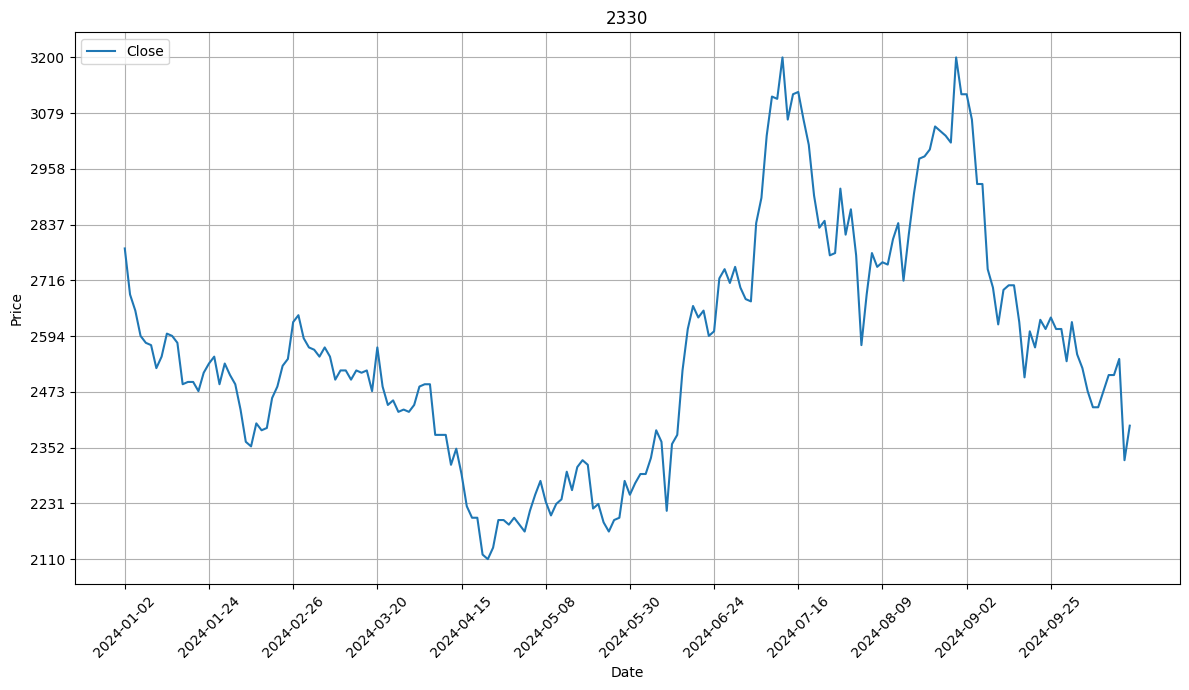

In [11]:
# 將收盤價可視化
import matplotlib.pyplot as plt
import numpy as np  # Import numpy for linspace

# 畫布尺寸大小設定
plt.figure(figsize=(12, 7))

# 設定要繪製的資料欄位
plt.plot(df['收盤價'], label='Close')

# 設定 x 軸的時間
num = 12
date = df["日期"].dt.strftime('%Y-%m-%d')
plt.xticks(date[::len(date)//num].index,
           date[::len(date)//num],
           rotation=45)

# 設定圖表的標題，x 軸和 y 軸的標籤
plt.title('2330')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)

# 設定 y 軸刻度，平均間隔顯示十個數字
# Get the minimum and maximum values of the '收盤價' column
ymin = df['收盤價'].min()
ymax = df['收盤價'].max()

# Generate 10 evenly spaced values between ymin and ymax
yticks = np.linspace(ymin, ymax, 10)
# Set the y-axis ticks to the generated values
plt.yticks(yticks)

plt.tight_layout()

# 顯示圖表
plt.show()

# 作業1：ARIMA

In [12]:
# ADF-檢查平穩性
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['收盤價'])
print('ADF統計量: %f' % result[0])
print('p-value: %f' % result[1])

ADF統計量: -1.663285
p-value: 0.450122


In [13]:
# p-value 大於 0.05，進行差分處理
data_diff = df['收盤價'].diff().dropna()

# 再次進行ADF檢定
result = adfuller(data_diff)
print('ADF統計量: %f' % result[0])
print('p-value: %f' % result[1])

ADF統計量: -4.383054
p-value: 0.000318


In [14]:
# 訓練, 測試集拆分
train_size = int(len(df['收盤價']) * 0.7)
train, test = df['收盤價'][:train_size], df['收盤價'][train_size:]

In [15]:
# 確定模型階數
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
def optimize_arima(train, p_values, d_values, q_values):
  best_score, best_cfg = float('inf'), None
  best_model = None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        try:
          model = ARIMA(train, order=(p, d, q))
          model_fit = model.fit()
          yhat = model_fit.forecast(steps=len(test))
          error = mean_squared_error(test, yhat)
          if error < best_score:
            best_score, best_cfg = error, (p, d, q)
            best_model = model_fit
        except:
          continue
  return best_cfg, best_model
# 定義參數範圍
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)
# 執行最佳化
best_cfg, best_model = optimize_arima(train, p_values, d_values, q_values)
# 印出最佳參數
print('最佳參數組合:', best_cfg)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: Us

最佳參數組合: (5, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
# 評估模型性能
from math import sqrt
# 預測
yhat = best_model.forecast(steps=len(test))
# 計算均方誤差
rmse_optimized = sqrt(mean_squared_error(test, yhat))
# 印出誤差RMSE
print('RMSE:', rmse_optimized)

RMSE: 176.48197111531928


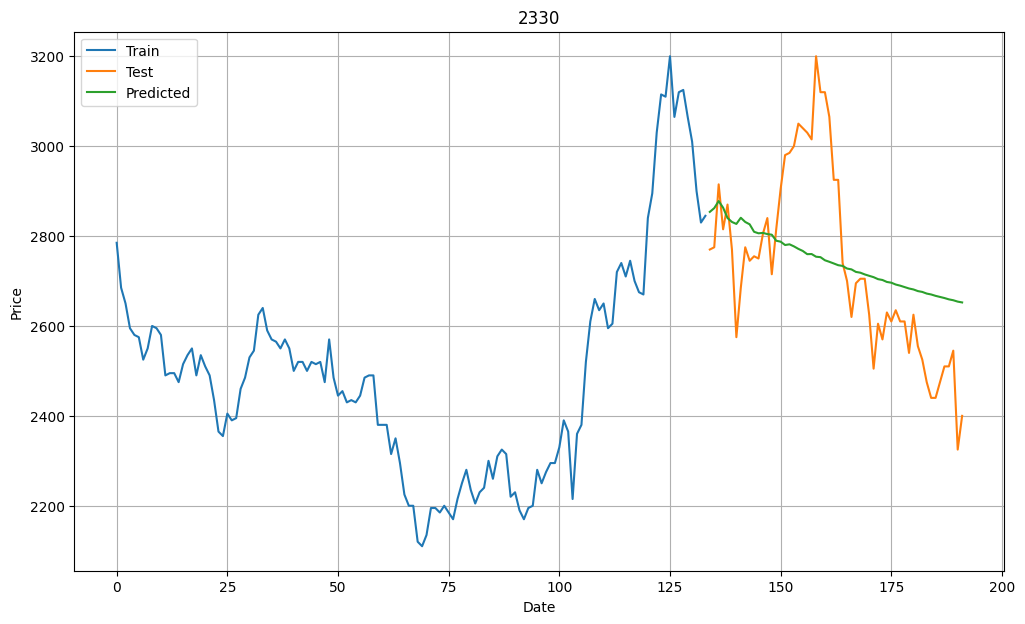

In [17]:
# 將預測結果可視化
# 畫布尺寸大小設定
plt.figure(figsize=(12, 7))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(yhat, label='Predicted')
plt.title('2330')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)
# 顯示圖表
plt.show()

In [18]:
# AR模型
# AR1 模型
ar1_model = ARIMA(train, order=(1, 0, 0)).fit()
ar1_pred = ar1_model.forecast(steps=len(test))
ar1_rmse = np.sqrt(mean_squared_error(test, ar1_pred))
print(f"AR1 RMSE: {ar1_rmse}")
# AR2 模型
ar2_model = ARIMA(train, order=(2, 0, 0)).fit()
ar2_pred = ar2_model.forecast(steps=len(test))
ar2_rmse = np.sqrt(mean_squared_error(test, ar2_pred))
print(f"AR2 RMSE: {ar2_rmse}")
# AR3 模型
ar3_model = ARIMA(train, order=(3, 0, 0)).fit()
ar3_pred = ar3_model.forecast(steps=len(test))
ar3_rmse = np.sqrt(mean_squared_error(test, ar3_pred))
print(f"AR3 RMSE: {ar3_rmse}")

AR1 RMSE: 184.5461672386647
AR2 RMSE: 186.5770492761964
AR3 RMSE: 208.8852355113918


# 作業2：建立量化交易策略

2-1：均價回歸策略 -- WMA

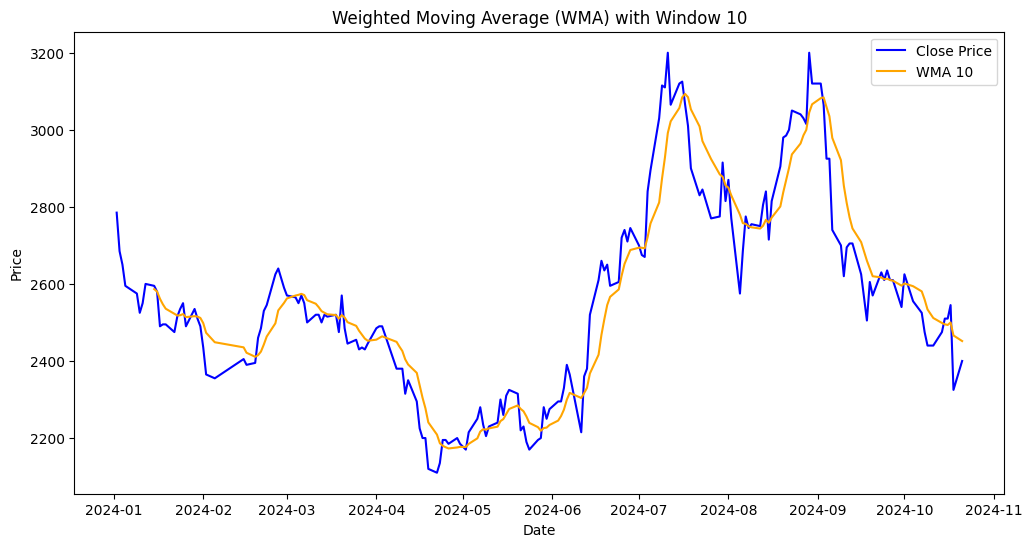

In [19]:
# 先計算十日WMA，並可視化查驗結果
import pandas as pd
import numpy as np

# 假設 df 包含 'date' 和 'close' 欄位
# df = pd.read_csv('data.csv') # 如果有檔案可以這樣讀入資料

def calculate_wma(prices, window):
    """
    計算加權移動平均（WMA）
    :param prices: 收盤價序列
    :param window: WMA 的視窗長度
    :return: WMA 序列
    """
    weights = np.arange(1, window + 1)  # 權重是 1 到 window 的數字
    wma = prices.rolling(window).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    return wma

# 設定 WMA 的視窗大小
window = 10

# 計算 WMA 並將結果存入 df
df['WMA'] = calculate_wma(df['收盤價'], window)

# 繪製 WMA 和收盤價圖
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['日期'], df['收盤價'], label='Close Price', color='blue')
plt.plot(df['日期'], df['WMA'], label=f'WMA {window}', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Weighted Moving Average (WMA) with Window {window}')
plt.legend()
plt.show()

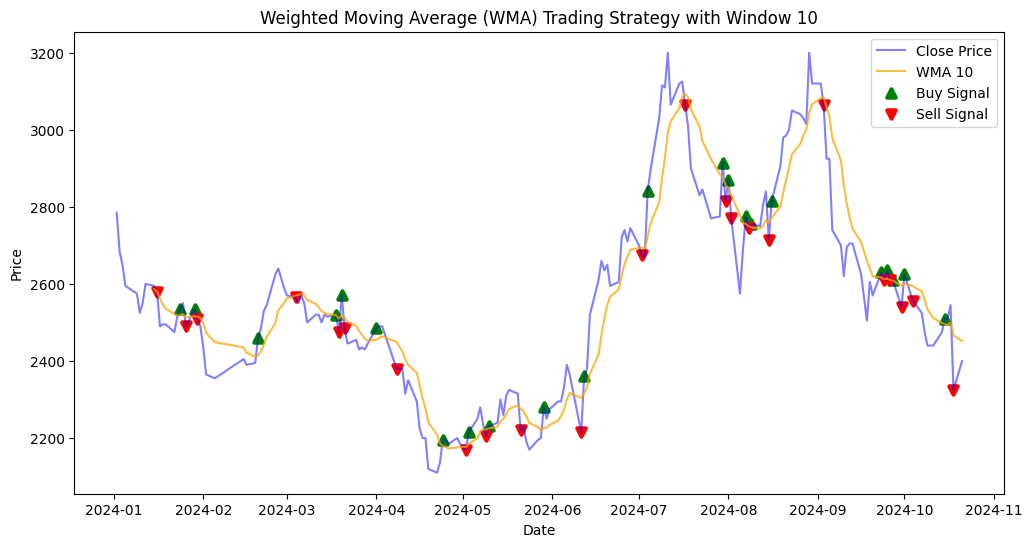

策略累積收益: -8.37%


In [22]:
# 初始化持有部位和資金狀態
df['Position'] = 0  # 0 代表空倉，1 代表持有多頭部位
df['Buy_Signal_Price'] = np.nan
df['Sell_Signal_Price'] = np.nan

# 實作交易邏輯(價格穿越WMA線--> 高到低則買入 低到高則賣出)
for i in range(1, len(df)):
    if df['收盤價'][i] > df['WMA'][i] and df['收盤價'][i - 1] <= df['WMA'][i - 1]:
        df.loc[i, 'Position'] = 1  # 買入信號
        df.loc[i, 'Buy_Signal_Price'] = df['收盤價'][i]
    elif df['收盤價'][i] < df['WMA'][i] and df['收盤價'][i - 1] >= df['WMA'][i - 1]:
        df.loc[i, 'Position'] = 0  # 賣出信號
        df.loc[i, 'Sell_Signal_Price'] = df['收盤價'][i]
    else:
        df.loc[i, 'Position'] = df['Position'][i - 1]  # 繼續保持之前的持倉狀態

# 繪製收盤價、WMA、買賣訊號
plt.figure(figsize=(12, 6))
plt.plot(df['日期'], df['收盤價'], label='Close Price', alpha=0.5, color='blue')
plt.plot(df['日期'], df['WMA'], label=f'WMA {window}', alpha=0.75, color='orange')

# 標示買入和賣出信號
plt.scatter(df['日期'], df['Buy_Signal_Price'], label='Buy Signal', marker='^', color='green', lw=3)
plt.scatter(df['日期'], df['Sell_Signal_Price'], label='Sell Signal', marker='v', color='red', lw=3)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Weighted Moving Average (WMA) Trading Strategy with Window {window}')
plt.legend()
plt.show()

# 計算策略收益
df['Returns'] = df['收盤價'].pct_change()  # 計算每日回報
df['Strategy_Returns'] = df['Returns'] * df['Position'].shift(1)  # 乘以前一天的部位
df['Cumulative_Returns'] = (1 + df['Strategy_Returns']).cumprod() - 1

# 印出最後策略的累積收益
print(f"策略累積收益: {df['Cumulative_Returns'].iloc[-1]:.2%}")

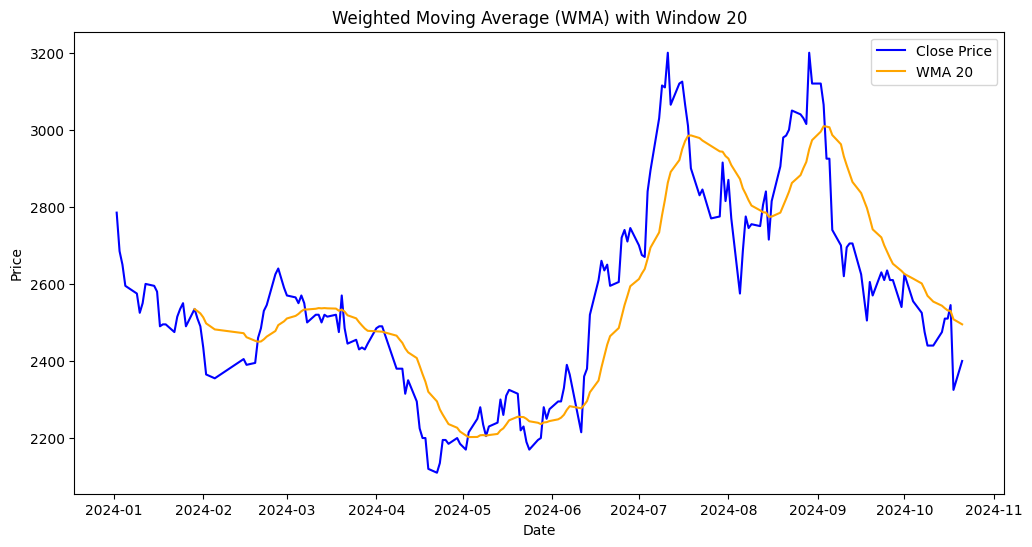

In [23]:
# 效果不太好 調整window_size=20看看
# 設定 WMA 的視窗大小
window = 20

# 計算 WMA 並將結果存入 df
df['WMA_20'] = calculate_wma(df['收盤價'], window)

# 繪製 WMA 和收盤價圖
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['日期'], df['收盤價'], label='Close Price', color='blue')
plt.plot(df['日期'], df['WMA_20'], label=f'WMA {window}', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Weighted Moving Average (WMA) with Window {window}')
plt.legend()
plt.show()

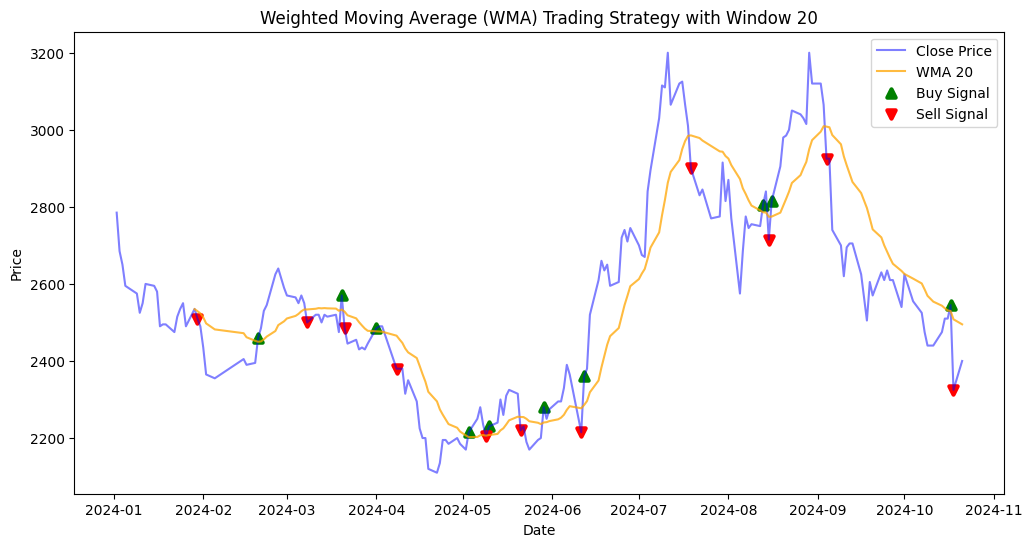

策略累積收益: 2.30%


In [25]:
# 初始化持有部位和資金狀態
df['Position'] = 0  # 0 代表空倉，1 代表持有多頭部位
df['Buy_Signal_Price'] = np.nan
df['Sell_Signal_Price'] = np.nan

# 實作交易邏輯(價格穿越WMA線--> 高到低則買入 低到高則賣出)
for i in range(1, len(df)):
    if df['收盤價'][i] > df['WMA_20'][i] and df['收盤價'][i - 1] <= df['WMA_20'][i - 1]:
        df.loc[i, 'Position'] = 1  # 買入信號
        df.loc[i, 'Buy_Signal_Price'] = df['收盤價'][i]
    elif df['收盤價'][i] < df['WMA_20'][i] and df['收盤價'][i - 1] >= df['WMA_20'][i - 1]:
        df.loc[i, 'Position'] = 0  # 賣出信號
        df.loc[i, 'Sell_Signal_Price'] = df['收盤價'][i]
    else:
        df.loc[i, 'Position'] = df['Position'][i - 1]  # 繼續保持之前的持倉狀態

# 繪製收盤價、WMA、買賣訊號
plt.figure(figsize=(12, 6))
plt.plot(df['日期'], df['收盤價'], label='Close Price', alpha=0.5, color='blue')
plt.plot(df['日期'], df['WMA_20'], label=f'WMA {window}', alpha=0.75, color='orange')

# 標示買入和賣出信號
plt.scatter(df['日期'], df['Buy_Signal_Price'], label='Buy Signal', marker='^', color='green', lw=3)
plt.scatter(df['日期'], df['Sell_Signal_Price'], label='Sell Signal', marker='v', color='red', lw=3)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Weighted Moving Average (WMA) Trading Strategy with Window {window}')
plt.legend()
plt.show()

# 計算策略收益
df['Returns'] = df['收盤價'].pct_change()  # 計算每日回報
df['Strategy_Returns'] = df['Returns'] * df['Position'].shift(1)  # 乘以前一天的部位
df['Cumulative_Returns'] = (1 + df['Strategy_Returns']).cumprod() - 1

# 印出最後策略的累積收益
print(f"策略累積收益: {df['Cumulative_Returns'].iloc[-1]:.2%}")

2-2：動量策略 -- RSI

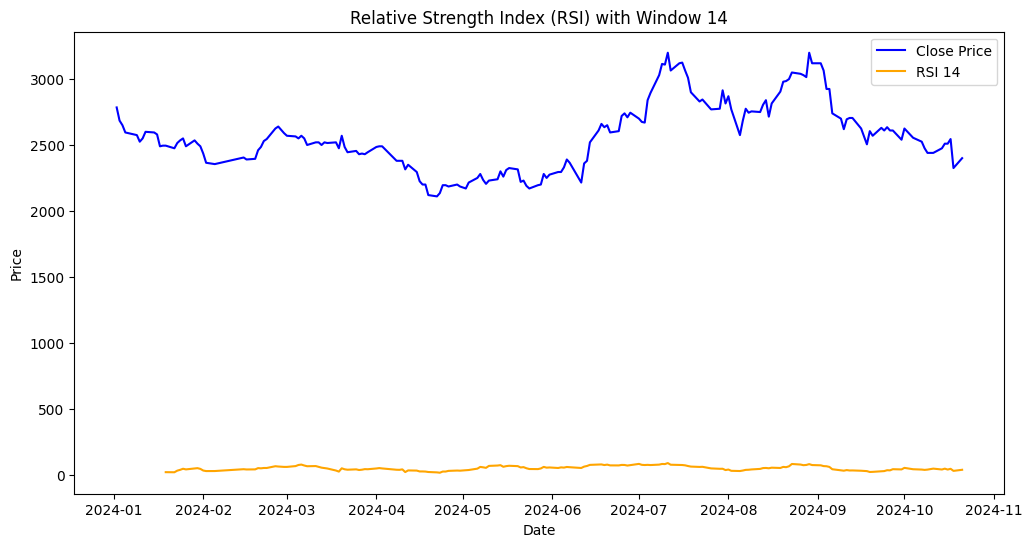

In [36]:
# 先計算十四日RSI，並可視化查驗結果
def calculate_rsi(prices, window):
    """
    計算 RSI 指標
    :param prices: 收盤價序列
    :param window: RSI 的視窗長度
    :return: RSI 序列
    """
    delta = prices.diff()  # 計算價格變動
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()  # 漲幅
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()  # 跌幅

    rs = gain / loss  # 相對強弱
    rsi = 100 - (100 / (1 + rs))  # RSI 計算公式
    return rsi

# 計算 RSI 並將結果存入 df
window = 14
df['RSI'] = calculate_rsi(df['收盤價'], window)

# 繪製 WMA 和收盤價圖
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['日期'], df['收盤價'], label='Close Price', color='blue')
plt.plot(df['日期'], df['RSI'], label=f'RSI {window}', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Relative Strength Index (RSI) with Window {window}')
plt.legend()
plt.show()

<ipython-input-38-46abbc47b633>:42: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
<ipython-input-38-46abbc47b633>:42: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


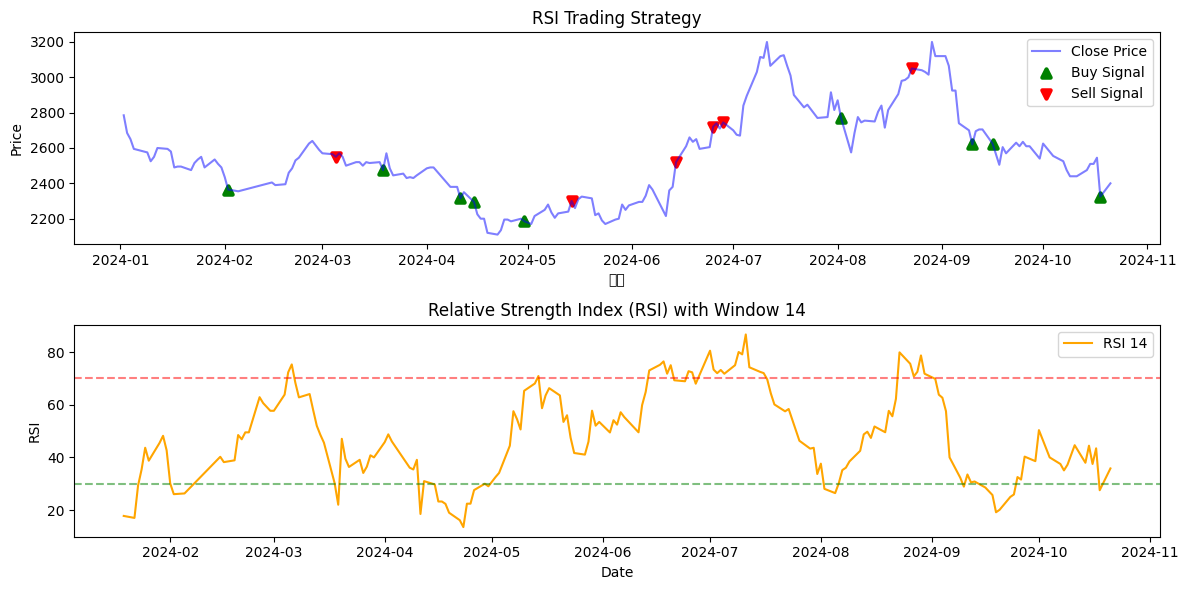

策略累積收益: 1.06%


In [38]:
# 初始化持有部位和交易信號
df['Position'] = 0  # 0 代表空倉，1 代表多頭部位
df['Buy_Signal_Price'] = np.nan
df['Sell_Signal_Price'] = np.nan

# 實作交易邏輯
for i in range(1, len(df)):
    if df['RSI'][i] < 30 and df['RSI'][i - 1] >= 30:
        df.loc[i, 'Position'] = 1  # 買入信號
        df.loc[i, 'Buy_Signal_Price'] = df['收盤價'][i]
    elif df['RSI'][i] > 70 and df['RSI'][i - 1] <= 70:
        df.loc[i, 'Position'] = 0  # 賣出信號
        df.loc[i, 'Sell_Signal_Price'] = df['收盤價'][i]
    else:
        df.loc[i, 'Position'] = df['Position'][i - 1]  # 繼續保持之前的持倉狀態

# 繪製收盤價、RSI、買賣訊號
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)  # 第一張圖：收盤價與買賣信號
plt.plot(df['日期'], df['收盤價'], label='Close Price', alpha=0.5, color='blue')

# 標示買入和賣出信號
plt.scatter(df['日期'], df['Buy_Signal_Price'], label='Buy Signal', marker='^', color='green', lw=3)
plt.scatter(df['日期'], df['Sell_Signal_Price'], label='Sell Signal', marker='v', color='red', lw=3)

plt.title('RSI Trading Strategy')
plt.xlabel('日期')
plt.ylabel('Price')
plt.legend()

# 第二張圖：RSI
plt.subplot(2, 1, 2)
plt.plot(df['日期'], df['RSI'], label=f'RSI {window}', color='orange')
plt.axhline(30, linestyle='--', alpha=0.5, color='green')  # 超賣線
plt.axhline(70, linestyle='--', alpha=0.5, color='red')    # 超買線

plt.title(f'Relative Strength Index (RSI) with Window {window}')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()

plt.tight_layout()
plt.show()

# 計算策略收益
df['Returns'] = df['收盤價'].pct_change()  # 計算每日回報
df['Strategy_Returns'] = df['Returns'] * df['Position'].shift(1)  # 乘以前一天的部位
df['Cumulative_Returns'] = (1 + df['Strategy_Returns']).cumprod() - 1

# 印出最後策略的累積收益
print(f"策略累積收益: {df['Cumulative_Returns'].iloc[-1]:.2%}")